1. 공분산 계산

    1-1. spacetrack 에서 tle 가져오기

    1-2. RIC, NTW 좌표계의 공분산 

    1-3. 각각의 axis 마다  residual의  scatter

2. residual variation

IMPORT

In [1]:
from sgp4.api import Satrec
from sgp4.api import jday
import numpy as np
from datetime import datetime
import json
import configparser
import requests

필요함수 정의

In [20]:
# ECI 좌표를 NTW로 변환
def ECI_To_NTW(r_true, v_true,r_ECI, v_ECI):
    T = v_true/np.linalg.norm(v_true)

    rv_ECI = np.cross(r_true, v_true)
    W = rv_ECI/np.linalg.norm(rv_ECI)

    N = np.cross(T,W)

    # 3*3 X 3*2 =(N T W ) X ( r v )
    # NTW = (np.vstack((T,N,W)))#VNC
    NTW = np.linalg.inv(np.transpose(np.vstack((T,N,W)))) # 뭐가 맞냐...
    state_ECI = np.transpose(np.vstack((r_ECI, v_ECI))) 
    state_NTW = NTW@state_ECI 
    r_NTW = state_NTW[:,0]
    V_NTW = state_NTW[:,1]

    return r_NTW, V_NTW # 변환된 좌표계로 보내줌.
# ECI 좌표를 RSW로 변환
def ECI_To_RSW(r_true, v_true,,r_ECI, v_ECI):
    R = r_true/np.linalg.norm(r_true)
    rv_ECI = np.cross(r_true, v_true)
    W = rv_ECI/np.linalg.norm(rv_ECI)
    S=np.cross(W,R)

    RSW = (np.vstack((R,S,W)))
    state_ECI = np.transpose(np.vstack((r_ECI,v_ECI)))
    state_RSW = RSW@state_ECI

    r_RSW = state_RSW[:,0]
    V_RSW = state_RSW[:,1]

    return r_RSW, V_RSW # 변환된 좌표계로 보내줌.
# string을 datetime으로 변환
def str_to_datetime(date_str):

    return datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')
# TLE데이터를 통해 datetime시점에서의 statevector 계산
def get_state_ECI(epoch_target, TLE_Line1, TLE_Line2,i):
    target_day=epoch_target
    firstLine=TLE_Line1
    secondLine=TLE_Line2

    yr, mon, day = target_day.year, target_day.month, target_day.day
    hour, min, sec = target_day.hour, target_day.minute, target_day.second
    jd, fr = jday(yr, mon, day, hour, min, sec)

    satellite = Satrec.twoline2rv(firstLine[i],secondLine[i]) 
    e, r, v = satellite.sgp4(jd,fr)
    r_np=np.array(r)
    v_np=np.array(v)
    return r_np, v_np
# spack-track TLE 주소를 알고 있는 상태에서 특정 feature 불러오기
def get_tle_element(feature):
    param=feature
    # set of satellite ids of objects included in TLE data
    SATNO_LIST = []

    # Use configparser package to pull in the ini file (pip install configparser)
    config = configparser.ConfigParser()
    config.read("./Login.ini")
    configUsr = config.get("configuration", "username")
    configPwd = config.get("configuration", "password")
    siteCred = {'identity': configUsr, 'password': configPwd}

    with requests.Session() as session:
        # run the session in a with block to force session to close if we exit

        # need to log in first. note that we get a 200 to say the web site got the data, not that we are logged in
        response = session.post(uriBase + requestLogin, data=siteCred)
        if response.status_code != 200:
            print("Error, POST fail on login")

        # this query picks up objects from the catalog. Note - a 401 failure shows you have bad credentials
        response = session.get(uriBase + requestCmdAction + requestFindObjects)
        if response.status_code != 200:
            print("Error, GET fail on request")

        data = json.loads(response.text)
        for object in data:
            SATNO = object[f'{feature}']
            SATNO_LIST.append(SATNO)
    
        session.close()
        SATNO_LIST=np.array(SATNO_LIST).reshape(-1,1)
    return SATNO_LIST 
# 상삼각행렬 부분만 추출
def upper_triangular_matrix_to_list(matrix):
    # 행렬의 차원 (행과 열의 수) 가져오기
    num_rows, num_cols = len(matrix), len(matrix[0])

    upper_triangular_elements = []
    for i in range(num_rows):
        for j in range(i, num_cols):  # 주 대각선과 그 위의 요소만 저장
            upper_triangular_elements.append(matrix[i][j])

    return upper_triangular_elements
# MAPE
def calculate_mape(actual, predicted):
    if len(actual) != len(predicted):
        raise ValueError("두 리스트는 길이가 동일해야 합니다.")

    n = len(actual)
    sum_percentage_errors = 0

    for i in range(n):
        if actual[i] != 0:  # 분모가 0이 아닌 경우에만 오차를 계산
            absolute_error = abs(actual[i] - predicted[i])
            percentage_error = (absolute_error / actual[i]) * 100
            sum_percentage_errors += percentage_error

    mape = sum_percentage_errors / n
    return mape

SyntaxError: invalid syntax (3913197807.py, line 20)

## Target 위성 리스트

KOMPSAT-2

In [6]:
uriBase = "https://www.space-track.org"
requestLogin = "/ajaxauth/login"
requestCmdAction = "/basicspacedata/query"

objnum = 29268   #위성번호
startdate = "2011-09-12" #시작일
enddate = "2011-09-27" #종료일
requestFindObjects = r= f"/class/tle/EPOCH/>{startdate}%2C<{enddate}/NORAD_CAT_ID/{objnum}/orderby/EPOCH%20asc"

LAGEOS -1

In [3]:
uriBase = "https://www.space-track.org"
requestLogin = "/ajaxauth/login"
requestCmdAction = "/basicspacedata/query"

objnum = 8820   #위성번호
startdate = "2003-03-01" #시작일
enddate = "2003-03-16" #종료일
requestFindObjects = r= f"/class/tle/EPOCH/>{startdate}%2C<{enddate}/NORAD_CAT_ID/{objnum}/orderby/EPOCH%20asc"

HEO

In [154]:
uriBase = "https://www.space-track.org"
requestLogin = "/ajaxauth/login"
requestCmdAction = "/basicspacedata/query"

objnum = 28544   #위성번호
startdate = "2015-11-09" #시작일
enddate = "2015-11-24" #종료일
requestFindObjects = r= f"/class/tle/EPOCH/>{startdate}%2C<{enddate}/NORAD_CAT_ID/{objnum}/orderby/EPOCH%20asc"

LEO

In [3]:
uriBase = "https://www.space-track.org"
requestLogin = "/ajaxauth/login"
requestCmdAction = "/basicspacedata/query"

objnum=22675 #위성번호
# startdate="2015-11-09" #시작일
startdate="2014-01-01" #시작일
enddate="2015-11-24" #종료일
requestFindObjects = r= f"/class/tle/EPOCH/>{startdate}%2C<{enddate}/NORAD_CAT_ID/{objnum}/orderby/EPOCH%20asc"


###  특정 위성의 historical TLE 데이터 가져오기

In [8]:

EPOCH = get_tle_element("EPOCH")
TLE_LINE1 = get_tle_element("TLE_LINE1")
TLE_LINE2 = get_tle_element("TLE_LINE2")
TLE=np.concatenate((EPOCH,TLE_LINE1, TLE_LINE2), axis=1)


epoch = [arr[0] for arr in TLE]
Line1 = [arr[1] for arr in TLE]
Line2 = [arr[2] for arr in TLE]

epoch_valid = np.vectorize(str_to_datetime)(epoch) #datetime으로 변환.


# 1. 공분산

1. 과거 TLE 데이터를 통해서 현재 시점을 예측한 값
2. 현재 TLE 데이터를 통해서 나온 값
3. 잔차 계산 후 NTW or RSW로 변환
3. 두 값의 잔차의 평균, 분산(공분산) 계산.

residual 계산 후 변환

### (1) RSW 좌표계로 변환

In [9]:
most_recent_epoch = epoch_valid[-1] # 가장 최근시점을 예측한다.
N = epoch_valid.size #총 TLE 개수 24개 
delta_r = []
delta_v = []

true_position, true_velocity = get_state_ECI(most_recent_epoch, Line1, Line2, N-1)

for i in range(N-1): # 기준 시점은 제외.
    r_ECI, v_ECI = get_state_ECI(most_recent_epoch, Line1, Line2,i)
    r_residual = r_ECI-true_position
    v_residual = v_ECI-true_velocity
    r_RSW ,v_RSW= (ECI_To_RSW(true_position, true_velocity, r_residual, v_residual))

    r_RSW = tuple(r_RSW)
    v_RSW = tuple(v_RSW)
    
    delta_r.append((r_RSW)) #잔차 r
    delta_v.append((v_RSW)) #잔차 v

### (2) NTW 좌표계로 변환

In [5]:
most_recent_epoch = epoch_valid[-1] # 가장 최근시점을 예측한다.

N = epoch_valid.size #총 TLE 개수 24개 

delta_r = []
delta_v = []

true_position, true_velocity = get_state_ECI(most_recent_epoch, Line1, Line2, N-1)

for i in range(N-1): # 기준 시점은 제외.
    r_ECI, v_ECI = get_state_ECI(most_recent_epoch, Line1, Line2,i)
    r_residual = r_ECI-true_position
    v_residual = v_ECI-true_velocity
    r_NTW ,v_NTW = (ECI_To_NTW(true_position, true_velocity, r_residual, v_residual))

    r_NTW = tuple(r_NTW)
    v_NTW = tuple(v_NTW)
    
    delta_r.append((r_NTW)) #잔차 r
    delta_v.append((v_NTW)) #잔차 v


### 공분산 계산

In [10]:
delta_r_np = np.array(delta_r) # 23 X 3
delta_v_np = np.array(delta_v) # 23 X 3
bar_X_epoch = np.hstack((delta_r_np, delta_v_np)) # 23 X 6

# 평균 계산
m = np.mean(bar_X_epoch,axis=0) # 1 X 6

a=bar_X_epoch-m

covariance = np.zeros((6, 6))

for i in range(len(a)):
    delta_X = np.array(a[i]).reshape(6, 1) # 6 X 1
    delta_X_T = np.transpose(delta_X) # 1 X 6
    temp = delta_X@delta_X_T # 6 X 6
    covariance += temp
covariance = covariance/len(a)

#공분산 출력하기
for i in range(covariance.shape[0]):
    for j in range(covariance.shape[1]):
        print(f'{covariance[i,j]}   ',end="")
    print('\n')

0.0335596559758956   0.4179412913695162   -0.038041029863396116   -0.00046196376200459627   -3.6561156816757826e-05   -1.5248246977193375e-05   

0.4179412913695162   18.830082059218334   -0.49901866027017644   -0.02030026128354143   -0.0004831327045917514   -0.00025409334045505694   

-0.038041029863396116   -0.49901866027017644   0.045994422298648835   0.0005492720653050179   4.151192487625002e-05   1.6388766240420976e-05   

-0.00046196376200459627   -0.02030026128354143   0.0005492720653050179   2.1891857769063736e-05   5.329758339638116e-07   2.7938906161703677e-07   

-3.6561156816757826e-05   -0.0004831327045917514   4.151192487625002e-05   5.329758339638116e-07   3.9907594824467995e-08   1.6755156405070376e-08   

-1.5248246977193375e-05   -0.00025409334045505694   1.6388766240420976e-05   2.7938906161703677e-07   1.6755156405070376e-08   8.659652194394976e-09   



### MAPE 계산 ( 상삼각행렬 요소만 )

In [11]:
# 상삼각행렬의 요소만 리스트로 변환
cov1=upper_triangular_matrix_to_list(covariance)

# 논문 계산 결과
Komsat2_covariance = [0.034238,0.42645,-0.03883,-0.00047,-3.73e-05,-1.55e-05,19.222,-0.50948,-0.02072,-0.00049,-0.00026,\
                  4.70e-02,0.00056,4.24e-05,1.67e-5,2.23e-5,5.44e-07,2.85e-07,\
                    4.07e-08,1.71e-08,8.81e-09]
Lageous_covariance=[0.378619709,-0.034359821,0.027715274,1.5511e-05,-0.000171498,-1.90966e-05,0.004002483,-0.002717183,\
                    -1.81855e-06,1.5463e-05,1.89775e-06,0.008430228,1.22177e-06,-1.21872e-05,-5.33055e-06,8.26397e-10,\
                        -6.9792e-09,-8.54481e-10,7.79043e-08,8.3125e-09,3.77679e-09]

# 논문계산결과와 비교해 MAPE 계산
print(f'MAPE:{round(calculate_mape(Lageous_covariance, cov1),4)}')

MAPE:95608.8064


### 공분산 csv로 저장

In [15]:
import pandas as pd
row_index = ['R_v(km)', 'R_n(km)', 'R_c(km)','V_v(km/sec)', 'V_n(km/sec)', 'V_c(km/sec)']
col_index = ['R_v(km)', 'R_n(km)', 'R_c(km)','V_v(km/sec)', 'V_n(km/sec)', 'V_c(km/sec)']
# 배열을 데이터프레임으로 변환하고 인덱스를 설정
covariance_6x6 = pd.DataFrame(covariance, index=row_index, columns=col_index)

# CSV 파일에 쓰기
covariance_6x6.to_csv('output.csv')

# 2. R, S, W 축별 residual variation Scatter

In [21]:
N = epoch_valid.size #총 TLE 개수 24개 
np.set_printoptions(formatter={'float': lambda x: "{:.12f}".format(x)})
delta_r = []
delta_v = []
delta_t = []
for i in range(N-1,-1,-1): # 기준 시점은 제외.
    epoch_true = epoch_valid[i]
    r_true, v_true = get_state_ECI(epoch_true, Line1, Line2,i)

    for j in range(i-1):
        epoch_estimate = epoch_valid[j]
        timedelta = epoch_true -epoch_estimate
        delta_t.append(timedelta.days+timedelta.seconds/(3600)/24) #시간구하고

        r_estimate, v_estimate = get_state_ECI(epoch_true, Line1, Line2,j)
 
        r_res = r_estimate-r_true
        v_res = v_estimate-v_true
        #RSW 또는 NTW 선택
        r_RSW ,v_RSW= (ECI_To_RSW(r_true, v_true, r_res, v_res))
        # r_RSW ,v_RSW= (ECI_To_NTW(r_true, v_true, r_res, v_res))

        r_RSW=tuple(r_RSW)
        v_RSW=tuple(v_RSW)
    
        delta_r.append((r_RSW)) #잔차 r
        delta_v.append((v_RSW)) #잔차 v_RSW

In [22]:
Radial = [arr[0] for arr in delta_r]
Intrack = [arr[1] for arr in delta_r]
Crosstrack = [arr[2] for arr in delta_r]

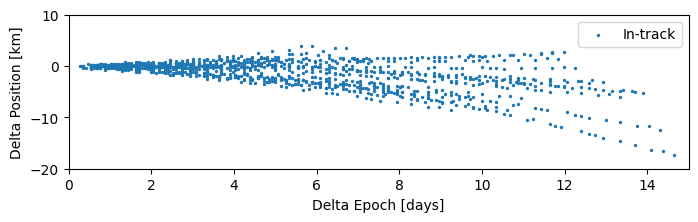

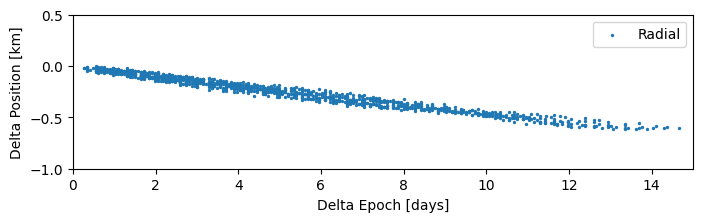

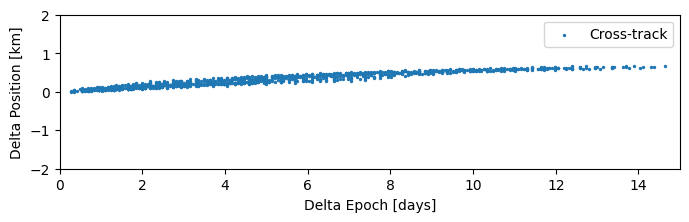

In [24]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(8,2))


plt.scatter(delta_t,Intrack, s=2,label="In-track")
plt.xlim(0, 15)  # Subplot 1의 x축 눈금 설정
plt.ylim(-20,10) # Subplot 1의 y축 눈금 설정
plt.xlabel("Delta Epoch [days]")
plt.ylabel("Delta Position [km]")
plt.legend()

fig=plt.figure(figsize=(8,2))
plt.scatter(delta_t,Radial ,s=2,label="Radial")
plt.xlim(0, 15)   # Subplot 1의 x축 눈금 설정
plt.ylim(-1,0.5) 
plt.xlabel("Delta Epoch [days]")
plt.ylabel("Delta Position [km]")
plt.legend()

fig=plt.figure(figsize=(8,2))
plt.scatter(delta_t,Crosstrack , s=2,label="Cross-track")
plt.xlim(0, 15)   # Subplot 1의 x축 눈금 설정
plt.ylim(-2, 2) # Subplot 1의 y축 눈금 설정
plt.xlabel("Delta Epoch [days]")
plt.ylabel("Delta Position [km]")
plt.legend()
plt.show()